# Correlations Between Heating Frequency and Emission Measure Slope

In [191]:
import os

import numpy as np
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
import astropy.constants as const
from sunpy.map import Map,GenericMap

import synthesizAR
from synthesizAR.util import EMCube
from synthesizAR.instruments import InstrumentHinodeEIS

sns.set_palette('deep')

%matplotlib inline

In [155]:
base = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn{}/'

In [138]:
field = synthesizAR.Skeleton.restore(os.path.join(base,'field_checkpoint'))

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-23 01:23:45,972 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-23 01:23:45,973 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-23 01:23:45,974 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-23 01:23:45,975 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-23 01:23:45,976 Parameters: cosmological_simulation   = 0.0


In [139]:
eis = InstrumentHinodeEIS(u.Quantity((7.5e3,12.5e3),u.s))

In [140]:
observer = synthesizAR.Observer(field,[eis],ds=field._convert_angle_to_length(0.4*u.arcsec))
observer.build_detector_files(base)

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [141]:
average_wait_times = np.empty(observer.total_coordinates.shape[0])
cur_coord = 0
for j,loop in enumerate(field.loops):
    tmp_wait_times = []
    for i,event in enumerate(loop.hydro_configuration['heating']['events']):
        if eis.observing_time[0].value <= event['event']['rise_start'] <= eis.observing_time[-1].value and i>0:
            tmp_wait_times.append(event['event']['rise_start'] - loop.hydro_configuration['heating']['events'][i-1]['event']['rise_end'])
    if len(tmp_wait_times) == 0:
        mean_wait_time = 0
    else:
        mean_wait_time = np.array(tmp_wait_times).mean()
    inc = observer._interpolated_loop_coordinates[j].shape[0]
    average_wait_times[cur_coord:(cur_coord+inc)] = mean_wait_time
    cur_coord += inc

In [142]:
coord_hist,edges = np.histogramdd(observer.total_coordinates.value[:,:2],
                                  bins=[eis.bins.x,eis.bins.y],
                                  range=[eis.bin_range.x,eis.bin_range.y]
                             )

In [143]:
wait_time_hist,_ = np.histogramdd(observer.total_coordinates.value[:,:2],
                                  bins=[eis.bins.x,eis.bins.y],
                                  range=[eis.bin_range.x,eis.bin_range.y],
                                  weights=average_wait_times
                                 )

In [144]:
wait_time_hist = wait_time_hist/np.where(coord_hist==0,1,coord_hist)

In [145]:
wait_time_hist = gaussian_filter(wait_time_hist.T,(eis.channels[0]['gaussian_width']['y'].value,
                                                   eis.channels[0]['gaussian_width']['x'].value))

In [146]:
wait_time_map = GenericMap(wait_time_hist,eis.make_fits_header(field,eis.channels[0]))

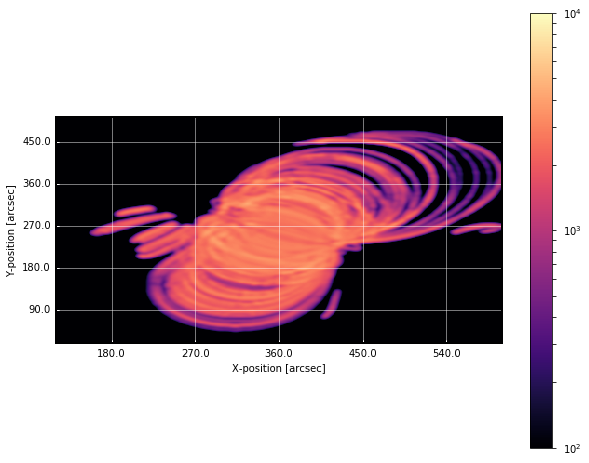

In [147]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection=wait_time_map)
im = wait_time_map.plot(cmap=plt.get_cmap('magma'),title=False,
                        norm=matplotlib.colors.SymLogNorm(1,vmin=100,vmax=1e4))
fig.colorbar(im,ax=ax)

In [148]:
slope_map = (EMCube
             .restore('../data/em_cubes_true_tn2500_t7500-12500.h5')
             .make_slope_map(em_threshold=1e25*u.cm**(-5),
                             temperature_bounds=u.Quantity((1e6,4e6),u.K),
                             rsquared_tolerance=0.5
                            )
            )
#slope_map.data = gaussian_filter(slope_map.data,(1,#eis.channels[0]['gaussian_width']['y'].value,
#                                                 1#eis.channels[0]['gaussian_width']['x'].value
#                                                )
#                                )

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


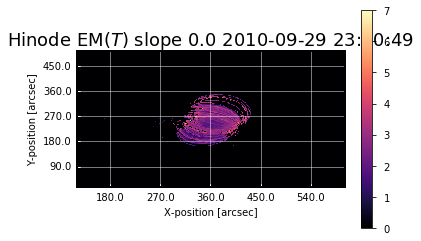

In [149]:
slope_map.peek(vmin=0,vmax=7,cmap=plt.get_cmap('magma'))

In [150]:
flat_slopes = slope_map.data.flatten()

In [151]:
flat_wait_times = wait_time_map.data.flatten()

In [152]:
flat_wait_times = flat_wait_times[flat_slopes>0]
flat_slopes = flat_slopes[flat_slopes>0]

In [200]:
frequencies = [250,750,2500,5000]
flat_slopes = {'true':{},'demreg':{}}
flat_wait_times = {'true':{},'demreg':{}}

In [201]:
for slope_type in ['true','demreg']:
    for freq in frequencies:
        # load field and observer
        field = synthesizAR.Skeleton.restore(os.path.join(base.format(freq),'field_checkpoint'))
        observer = synthesizAR.Observer(field,[eis],ds=field._convert_angle_to_length(0.4*u.arcsec))
        observer.build_detector_files(base.format(freq))
        # aggregate heating wait times
        average_wait_times = np.empty(observer.total_coordinates.shape[0])
        cur_coord = 0
        for j,loop in enumerate(field.loops):
            tmp_wait_times = []
            for i,event in enumerate(loop.hydro_configuration['heating']['events']):
                if eis.observing_time[0].value <= event['event']['rise_start'] <= eis.observing_time[-1].value and i>0:
                    tmp_wait_times.append(event['event']['rise_start'] - loop.hydro_configuration['heating']['events'][i-1]['event']['rise_end'])
            if len(tmp_wait_times) == 0:
                mean_wait_time = 0
            else:
                mean_wait_time = np.array(tmp_wait_times).mean()
            inc = observer._interpolated_loop_coordinates[j].shape[0]
            average_wait_times[cur_coord:(cur_coord+inc)] = mean_wait_time
            cur_coord += inc
        # make into map
        coord_hist,edges = np.histogramdd(observer.total_coordinates.value[:,:2],
                                      bins=[eis.bins.x,eis.bins.y],
                                      range=[eis.bin_range.x,eis.bin_range.y]
                                 )
        wait_time_hist,_ = np.histogramdd(observer.total_coordinates.value[:,:2],
                                      bins=[eis.bins.x,eis.bins.y],
                                      range=[eis.bin_range.x,eis.bin_range.y],
                                      weights=average_wait_times
                                     )
        wait_time_hist = wait_time_hist/np.where(coord_hist==0,1,coord_hist)
        wait_time_hist = gaussian_filter(wait_time_hist.T,(eis.channels[0]['gaussian_width']['y'].value,
                                                           eis.channels[0]['gaussian_width']['x'].value))
        wait_time_map = GenericMap(wait_time_hist,eis.make_fits_header(field,eis.channels[0]))
        # load slope maps
        slope_map = (EMCube
                     .restore('../data/em_cubes_{}_tn{}_t7500-12500.h5'.format(slope_type,freq))
                     .make_slope_map(em_threshold=1e25*u.cm**(-5),
                                     temperature_bounds=u.Quantity((1e6,4e6),u.K),
                                     rsquared_tolerance=0.9))
        # flatten and remove zeros
        tmp_flat_slopes = slope_map.data.flatten()
        tmp_flat_wait_times = wait_time_map.data.flatten()
        flat_wait_times[slope_type][freq] = tmp_flat_wait_times[tmp_flat_slopes>0]
        flat_slopes[slope_type][freq] = tmp_flat_slopes[tmp_flat_slopes>0]
    

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-23 01:51:47,407 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-23 01:51:47,408 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-23 01:51:47,409 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-23 01:51:47,410 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-23 01:51:47,411 Parameters: cosmological_simulation   = 0.0
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/s

(100, 5000)

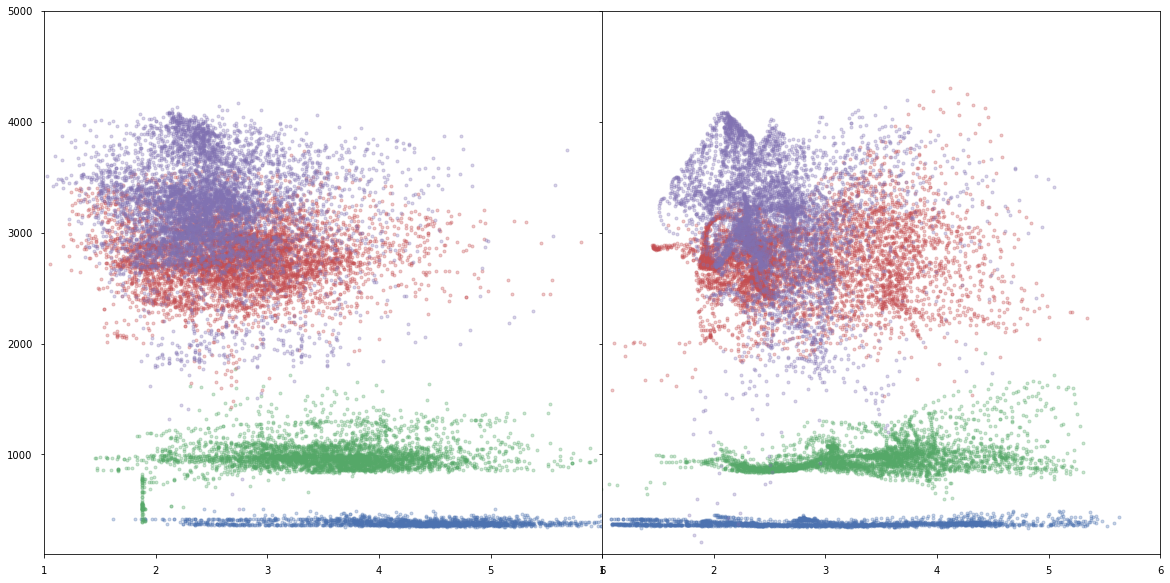

In [215]:
fig,axes = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0)
for i,freq in enumerate(frequencies):
    axes[0].scatter(flat_slopes['true'][freq],
                flat_wait_times['true'][freq],
                marker='.',alpha=0.3,color=sns.color_palette()[i])
    axes[1].scatter(flat_slopes['demreg'][freq],
                flat_wait_times['demreg'][freq],
                marker='.',alpha=0.3,color=sns.color_palette()[i])
axes[0].set_xlim([1,6])
axes[0].set_ylim([100,5000])
#plt.yscale('log')